<a href="https://colab.research.google.com/github/areias/slm-finetunig/blob/main/colab_axolotl_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning with Axolotl on google colab

---



In [4]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


## prepare data

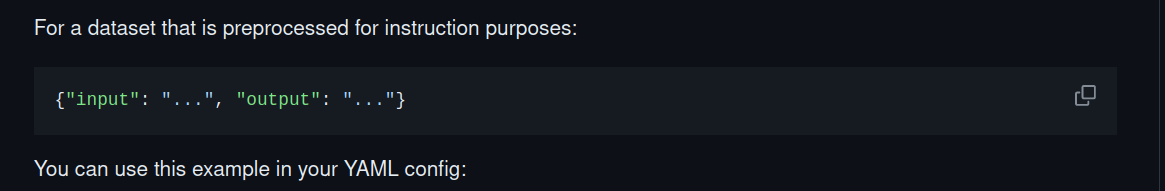

In [16]:
ls drive/MyDrive/mistral-finetune/data

nyt10m_finetuning-balanced.csv  nyt10m_test.csv             test_sample.json
nyt10m_finetuning.csv           test_sample_basepreds.json  train_sample.json


In [8]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/mistral-finetune/data/nyt10m_finetuning-balanced.csv")

In [13]:
df.loc[df['relation'].isna(),'relation']="None"


In [9]:
df.head()

,text,h_name,t_name,relation
0,There were also performers who were born in Lo...,Johnny Rivers,Louisiana,/people/person/place_of_birth
1,"Indeed , Mr. Chávez said Sunday that he wished...",Evo Morales,Bolivia,/people/person/nationality
2,"Indeed , Mr. Chávez said Sunday that he wished...",Evo Morales,Bolivia,/people/person/place_lived
3,Analysts contrast Mr. Chávez 's success at con...,Evo Morales,Bolivia,/people/person/nationality
4,"Ecuador 's new president , Rafael Correa , joi...",Evo Morales,Bolivia,/people/person/nationality


In [14]:
df.relation.value_counts() / len(df)

/people/person/place_lived                    0.176997
/location/located_in                          0.153581
/business/person/company                      0.125344
/location/administrative_division/country     0.082645
/people/person/nationality                    0.081956
None                                          0.081956
/business/location                            0.079890
/location/country/administrative_divisions    0.066804
/people/person/place_of_birth                 0.058540
/business/company/advisors                    0.048898
/people/deceasedperson/place_of_death         0.043388
Name: relation, dtype: float64

In [11]:
len(df)

1452

In [18]:
def preprocess(df):

    data = []

    for idx, sentence in enumerate(df['text'].unique()):
        output=[]
        for row in df[df['text']==sentence].iterrows():
            if row[1]['relation']=="None":
                output.append("None")
            else:
                output.append(tuple([row[1]['h_name'],row[1]['relation'],row[1]['t_name']]))
        data.append({"input": sentence,
                    "output": ", ".join([str(x) for x in output])})
    return data

In [19]:
data=preprocess(df)

In [26]:
data[0]['input']

"There were also performers who were born in Louisiana , including Lucinda Williams , Jerry Lee Lewis and Johnny Rivers , whose '' Secret Agent Man '' had a touch of bayou-country swamp-pop ."

In [28]:
!pip install -q jsonlines

In [29]:
import jsonlines

# Replace 'output.jsonl' with the desired output file path
output_file = 'drive/MyDrive/mistral-finetune/data/rel-ext-train.jsonl'

# Iterate through each row of the DataFrame and save as JSONL
with jsonlines.open(output_file, mode='w') as writer:
    for x in data:
        # Write dictionary to JSONL file
        writer.write(x)

In [30]:
!head -n 3 drive/MyDrive/mistral-finetune/data/rel-ext-train.jsonl

{"input": "There were also performers who were born in Louisiana , including Lucinda Williams , Jerry Lee Lewis and Johnny Rivers , whose '' Secret Agent Man '' had a touch of bayou-country swamp-pop .", "output": "('Johnny Rivers', '/people/person/place_of_birth', 'Louisiana'), ('Jerry Lee Lewis', '/people/person/place_of_birth', 'Louisiana')"}
{"input": "Indeed , Mr. Chávez said Sunday that he wished Mr. Correa the '' best of luck '' from Venezuela , where he appeared on television with President Evo Morales of Bolivia to commemorate the opening of a milk processing plant built in western Venezuela with financing from Iran .", "output": "('Evo Morales', '/people/person/nationality', 'Bolivia'), ('Evo Morales', '/people/person/place_lived', 'Bolivia')"}
{"input": "Analysts contrast Mr. Chávez 's success at consolidating power in Venezuela with the troubles faced by President Evo Morales in Bolivia , where a constitution-writing assembly has been stalled by fractious delegates and regi

In [17]:
df['text'].nunique()/2

487.0

In [5]:
import json
with open("drive/MyDrive/mistral-finetune/data/nyt10m_finetuning-balanced.csvz","r") as file:
    data = json.load(file)

In [6]:
data[0]

{'id': '10476',
 'tokens': ['CINCINNATI', 'AT', 'COLORADO'],
 'pos_tags': [22, 22, 22],
 'chunk_tags': [11, 12, 12],
 'ner_tags': [3, 0, 5],
 'labels': ['B-ORG', 'O', 'B-LOC'],
 'sentence': 'CINCINNATI AT COLORADO',
 'entities': {'PER': [],
  'ORG': ['CINCINNATI'],
  'LOC': ['COLORADO'],
  'MISC': []}}

In [7]:
len(data)

1000

In [14]:
x=data[0]
print({"input": x['sentence'],
 "output": x['entities']})

{'input': 'CINCINNATI AT COLORADO', 'output': {'PER': [], 'ORG': ['CINCINNATI'], 'LOC': ['COLORADO'], 'MISC': []}}


In [18]:
!pip install jsonlines

In [21]:
import jsonlines

# Replace 'output.jsonl' with the desired output file path
output_file = 'drive/MyDrive/mistral-finetune/data/train.jsonl'

# Iterate through each row of the DataFrame and save as JSONL
with jsonlines.open(output_file, mode='w') as writer:
    for x in data:
        # Convert row to dictionary
        line = {"input": x['sentence'],"output": x['entities']}
        # Write dictionary to JSONL file
        writer.write(line)

In [23]:
! head -n 5 drive/MyDrive/mistral-finetune/data/train.jsonl

{"input": "CINCINNATI AT COLORADO", "output": {"PER": [], "ORG": ["CINCINNATI"], "LOC": ["COLORADO"], "MISC": []}}
{"input": "Relations with Russia , which is our main partner , have great importance , \" Kuchma said .", "output": {"PER": ["Kuchma"], "ORG": [], "LOC": ["Russia"], "MISC": []}}
{"input": "He added : \" If no one asked , I never opened my mouth .", "output": {"PER": [], "ORG": [], "LOC": [], "MISC": []}}
{"input": "-- Steve Weizman , Copenhagen newsroom +45 33969650", "output": {"PER": ["Steve Weizman"], "ORG": [], "LOC": ["Copenhagen"], "MISC": []}}
{"input": "70 71 74", "output": {"PER": [], "ORG": [], "LOC": [], "MISC": []}}


In [1]:
import torch
# Check so there is a gpu available, a T4(free tier) is enough to run this notebook
assert (torch.cuda.is_available()==True)

## Install Axolotl and dependencies

In [34]:
!pip install torch=="2.1.2"
!pip install -e git+https://github.com/OpenAccess-AI-Collective/axolotl#egg=axolotl
!pip install flash-attn=="2.5.0"
!pip install deepspeed=="0.13.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.1 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.5.0-cp310-cp310-linux_x86_64.whl size=120823033 sha256=3335e74258645eb190597754d42c2fee391fbdeb772847f9e1de12da60450a33
  Stored in directory: /root/.cache/pip/wheels/9e/c3/22/a576eb5627fb2c30dc4679a33d67d34d922d6dbeb24a9119b2
Successfully built flash-attn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 7.8 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.13.1-py3-none-any.whl size=1350299 sha256=4b67716a2fa393588c09ebd0a4511b5e38d4792b095f831c1330230ce933436a
  Stored in directory: /root/.cache/pip/wheels/0f/fb/b5/b159b3500525eca167d8ca6e3a7e224b6075045cac90f47cf7
Successfully built d

## Create an yaml config file

https://github.com/OpenAccess-AI-Collective/axolotl/tree/main?tab=readme-ov-file#config

https://github.com/OpenAccess-AI-Collective/axolotl/blob/main/examples/mistral/Mistral-7b-example/config.yml

In [4]:
import yaml

# Your YAML string
yaml_string = """
base_model: mistralai/Mistral-7B-Instruct-v0.2
model_type: MistralForCausalLM
tokenizer_type: LlamaTokenizer
is_mistral_derived_model: true # sets padding to 'left'

# optional overrides to the bnb 4bit quantization configuration
bnb_config_kwargs:
  # These are default values
  llm_int8_has_fp16_weight: false
  bnb_4bit_quant_type: nf4
  bnb_4bit_use_double_quant: true

load_in_8bit: false
# Use bitsandbytes 4 bit
load_in_4bit: true
strict: false

datasets:
  - path: drive/MyDrive/mistral-finetune/data/rel-ext-train.jsonl
    type:
      system_prompt: ""
      field_system: system
      field_instruction: input
      field_output: output
      format: >
            [INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors',
            '/business/location', '/business/person/company', '/location/administrative_division/country',
            '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death',
            '/people/person/nationality', '/people/person/place_lived','/people/person/place_of_birth']

            What relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!

            The given sentence is: '{input}'

            If none present, answer: None.

            Respond with relationship triples, e.g. (head entity 1, relation 1, tail entity 1), (head entity 2, relation 2, tail entity 2), (...)

            Take care, your answer is only valid if it follows the correct format! [/INST]

# How much of the dataset to set aside as evaluation. 1 = 100%, 0.50 = 50%, etc. 0 for no eval.
val_set_size: 0.2

# Where to save the full-finetuned model to
output_dir: drive/MyDrive/mistral-finetune/rel-ext/r32alpha16

adapter: qlora
lora_model_dir:

sequence_len: 512
sample_packing: false
pad_to_sequence_len: true

lora_r: 32
lora_alpha: 16
lora_dropout: 0.05
lora_target_modules:
lora_target_linear: true # If true, will target all linear modules
lora_fan_in_fan_out:


# wandb configuration if you're using it
# Make sure your `WANDB_API_KEY` environment variable is set (recommended) or you login to wandb with `wandb login`.
wandb_mode: # "offline" to save run metadata locally and not sync to the server, "disabled" to turn off wandb
wandb_project: mistral-rel-finetune
wandb_entity: # A wandb Team name if using a Team
wandb_watch:
wandb_name: r32alpha16 # Set the name of your wandb run
wandb_run_id: # Set the ID of your wandb run
wandb_log_model: save_steps # "checkpoint" to log model to wandb Artifacts every `save_steps` or "end" to log only at the end of training


gradient_accumulation_steps: 1
# The number of samples to include in each batch. This is the number of samples sent to each GPU.
micro_batch_size: 2
num_epochs: 1
max_steps: 500
optimizer: paged_adamw_8bit
lr_scheduler: cosine
learning_rate: 0.000025

train_on_inputs: false
group_by_length: false
bf16: false
# Use CUDA fp16
fp16: true
tf32: false

gradient_checkpointing: true
early_stopping_patience:
resume_from_checkpoint:
local_rank:
logging_steps: 25
xformers_attention:
flash_attention: false

warmup_steps: 1
evals_per_epoch:
saves_per_epoch:
debug:
deepspeed:
weight_decay: 0.0
fsdp:
fsdp_config:
special_tokens:
  bos_token: "<s>"
  eos_token: "</s>"

"""

# Convert the YAML string to a Python dictionary
yaml_dict = yaml.safe_load(yaml_string)

# Specify your file path
file_path = 'drive/MyDrive/mistral-finetune/axolotl-mistral-relext-r32alpha16.yaml'

# Write the YAML file
with open(file_path, 'w') as file:
    yaml.dump(yaml_dict, file)


## Launch the training

In [5]:
# Buy using the ! the comand will be executed as a bash command
import os
os.environ["WANDB_API_KEY"] = "20475519ff6c5ed5b99e2432a603c688e3084404"
!accelerate launch -m axolotl.cli.train drive/MyDrive/mistral-finetune/axolotl-mistral-relext-r32alpha16.yaml

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
[2024-03-04 16:49:59,542] [INFO] [datasets.<module>:58] [PID:7864] PyTorch version 2.1.2 available.
[2024-03-04 16:49:59,543] [INFO] [datasets.<module>:95] [PID:7864] TensorFlow version 2.15.0 available.
[2024-03-04 16:49:59,544] [INFO] [datasets.<module>:108] [PID:7864] JAX version 0.4.23 available.
2024-03-04 16:50:01.529642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 16:50:01.529694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to reg

## Play with inference

In [ ]:
# Buy using the ! the comand will be executed as a bash command
!accelerate launch -m axolotl.cli.inference /content/test_axolotl.yaml \
    --qlora_model_dir="./qlora-out" --gradio